# Exogenous Variables: Time Series Analysis

The exogenous variables we have collected for this analysis include several crime, arrest, and jail activity metrics sampled at 30-day intervals. These are:

* 30-Day total misdemeanor crime, nonviolent felony crime, and violent felony crime counts.

* 30-Day total misdemeanor arrest, nonviolent felony arrest, and violent felony arrest counts.

* 30-Day DOC admission and discharge counts.

* 30-Day average length of stay (LOS).

To gain a better understanding of the trends within each exogenous variable (misdemeanor, nonviolent & violent felony crime and arrest counts), we conducted the same descriptive and exploratory tests as mentioned above for the exogenous variables (seasonal decomposition, ADF tests, ACF and PACF).

This notebook will analyze the trends in the 30 day time series signals collected in `01_get_data.ipynb`. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from functions import *
%matplotlib inline

## Step 1: Import Data

This data was saved in `01_get_data.ipynb`

In [3]:
_30day_pop_tot = pd.read_csv("../Data/_30_day_adp.csv", index_col = 0)
#specify data types for start and end date
_30day_pop_tot['Start Date'] = _30day_pop_tot['Start Date'].astype('datetime64[ns]')
_30day_pop_tot['End Date'] = _30day_pop_tot['End Date'].astype('datetime64[ns]')

_30day_pop_tot.head()

,Start Date,End Date,ADP
0,2016-05-15,2016-06-13,9820.0
1,2016-06-14,2016-07-13,9796.0
2,2016-07-14,2016-08-12,9730.0
3,2016-08-13,2016-09-11,9824.0
4,2016-09-12,2016-10-11,9845.0


In [4]:
#look at the last 30-day period
_30day_pop_tot.tail(1)

,Start Date,End Date,ADP
101,2024-08-31,2024-09-29,6509.0


In [5]:
joined_doc_ivs_df = pd.read_csv("../Data/_30_day_IVs.csv", index_col = 0)
#specify data types for start and end date
joined_doc_ivs_df['Start Date'] = joined_doc_ivs_df['Start Date'].astype('datetime64[ns]')
joined_doc_ivs_df['End Date'] = joined_doc_ivs_df['End Date'].astype('datetime64[ns]')
#add los in 30-day periods
joined_doc_ivs_df['Avg LOS (30D)'] = joined_doc_ivs_df['Avg LOS Days']/30
joined_doc_ivs_df.head()

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,Avg LOS (30D)
0,2016-05-15,2016-06-13,4935,4880,56.661485,1.888716
1,2016-06-14,2016-07-13,4897,4999,62.825000,2.094167
2,2016-07-14,2016-08-12,4871,4874,61.316523,2.043884
3,2016-08-13,2016-09-11,4600,4338,56.608826,1.886961
4,2016-09-12,2016-10-11,4519,4666,61.751337,2.058378


In [6]:
#look at the last 30-day period
joined_doc_ivs_df.tail(1)

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,Avg LOS (30D)
100,2024-08-01,2024-08-30,2005,1975,96.66447,3.222149


In [7]:
crime_data = pd.read_csv("../Data/_30_day_crime_counts.csv", index_col = 0)
#specify data types for start and end date
crime_data['Start Date'] = crime_data['Start Date'].astype('datetime64[ns]')
crime_data['End Date'] = crime_data['End Date'].astype('datetime64[ns]')

#get arrest data
arrest_data = pd.read_csv("../Data/_30_day_arrest_counts.csv", index_col = 0)
#specify data types for start and end date
arrest_data['Start Date'] = arrest_data['Start Date'].astype('datetime64[ns]')
arrest_data['End Date'] = arrest_data['End Date'].astype('datetime64[ns]')


In [8]:
crime_data.head()

,Start Date,End Date,total_felony_crimes,violent_felony_crimes,total_misdemeanor_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,rape_count,grand_larceny_count,grand_larceny_vehicle_count,weapons_count,nonviolent_felony_crimes
0,2016-05-15,2016-06-13,12504,3330,23148,30,1284,1876,1053,140,3651,585,466,9174
1,2016-06-14,2016-07-13,12792,3422,22376,32,1293,1958,1072,139,3795,559,418,9370
2,2016-07-14,2016-08-12,13079,3588,22312,46,1354,2046,1128,142,3855,628,379,9491
3,2016-08-13,2016-09-11,13320,3530,22284,37,1364,2001,1116,128,3805,657,506,9790
4,2016-09-12,2016-10-11,12309,3160,21337,33,1338,1674,1084,115,3621,561,444,9149


In [9]:
arrest_data.head()

,Start Date,End Date,total_felony_arrest,violent_felony_arrest,total_misdemeanor_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count,nonviolent_felony_arrest
0,2016-05-15,2016-06-13,7890,2353,17655,65,868,1349,402,71,852,89,614,5537
1,2016-06-14,2016-07-13,7647,2332,16604,89,785,1391,325,67,836,104,568,5315
2,2016-07-14,2016-08-12,7849,2465,15893,101,878,1409,385,77,815,85,499,5384
3,2016-08-13,2016-09-11,7812,2334,16682,79,826,1359,423,70,803,104,643,5478
4,2016-09-12,2016-10-11,7582,2187,16690,76,885,1168,426,58,767,114,565,5395


In [10]:
print(crime_data.tail(1)[['Start Date', 'End Date']])
print(arrest_data.tail(1)[['Start Date', 'End Date']])

   Start Date   End Date
97 2024-05-03 2024-06-01
   Start Date   End Date
97 2024-05-03 2024-06-01


As described above, the arrest and crime data are one data point behind the DOC data sets. We will need to find the best way to account for this missing data point. Since we are going to analyze the trends of each exogenous variable and use an ARIMA model to predict 12 future time periods, we might as well use the ARIMA model to predict the missing data point.

In [11]:
# Combine the dataframes into one big dataframe
exog_combined = pd.concat([joined_doc_ivs_df.iloc[:-1], crime_data[crime_data.columns.to_list()[2:]], arrest_data[arrest_data.columns.to_list()[2:]]], axis=1)
exog_combined.head()

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,Avg LOS (30D),total_felony_crimes,violent_felony_crimes,total_misdemeanor_crimes,murder_homicide_count,...,total_misdemeanor_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count,nonviolent_felony_arrest
0,2016-05-15,2016-06-13,4935,4880,56.661485,1.888716,12504.0,3330.0,23148.0,30.0,...,17655.0,65.0,868.0,1349.0,402.0,71.0,852.0,89.0,614.0,5537.0
1,2016-06-14,2016-07-13,4897,4999,62.825000,2.094167,12792.0,3422.0,22376.0,32.0,...,16604.0,89.0,785.0,1391.0,325.0,67.0,836.0,104.0,568.0,5315.0
2,2016-07-14,2016-08-12,4871,4874,61.316523,2.043884,13079.0,3588.0,22312.0,46.0,...,15893.0,101.0,878.0,1409.0,385.0,77.0,815.0,85.0,499.0,5384.0
3,2016-08-13,2016-09-11,4600,4338,56.608826,1.886961,13320.0,3530.0,22284.0,37.0,...,16682.0,79.0,826.0,1359.0,423.0,70.0,803.0,104.0,643.0,5478.0
4,2016-09-12,2016-10-11,4519,4666,61.751337,2.058378,12309.0,3160.0,21337.0,33.0,...,16690.0,76.0,885.0,1168.0,426.0,58.0,767.0,114.0,565.0,5395.0


In [12]:
exog_combined.tail(1)

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,Avg LOS (30D),total_felony_crimes,violent_felony_crimes,total_misdemeanor_crimes,murder_homicide_count,...,total_misdemeanor_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count,nonviolent_felony_arrest
99,2024-07-02,2024-07-31,1903,1907,93.435992,3.114533,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot Exogenous Variables to help visualize trends over time

In [13]:
import matplotlib.gridspec as gridspec

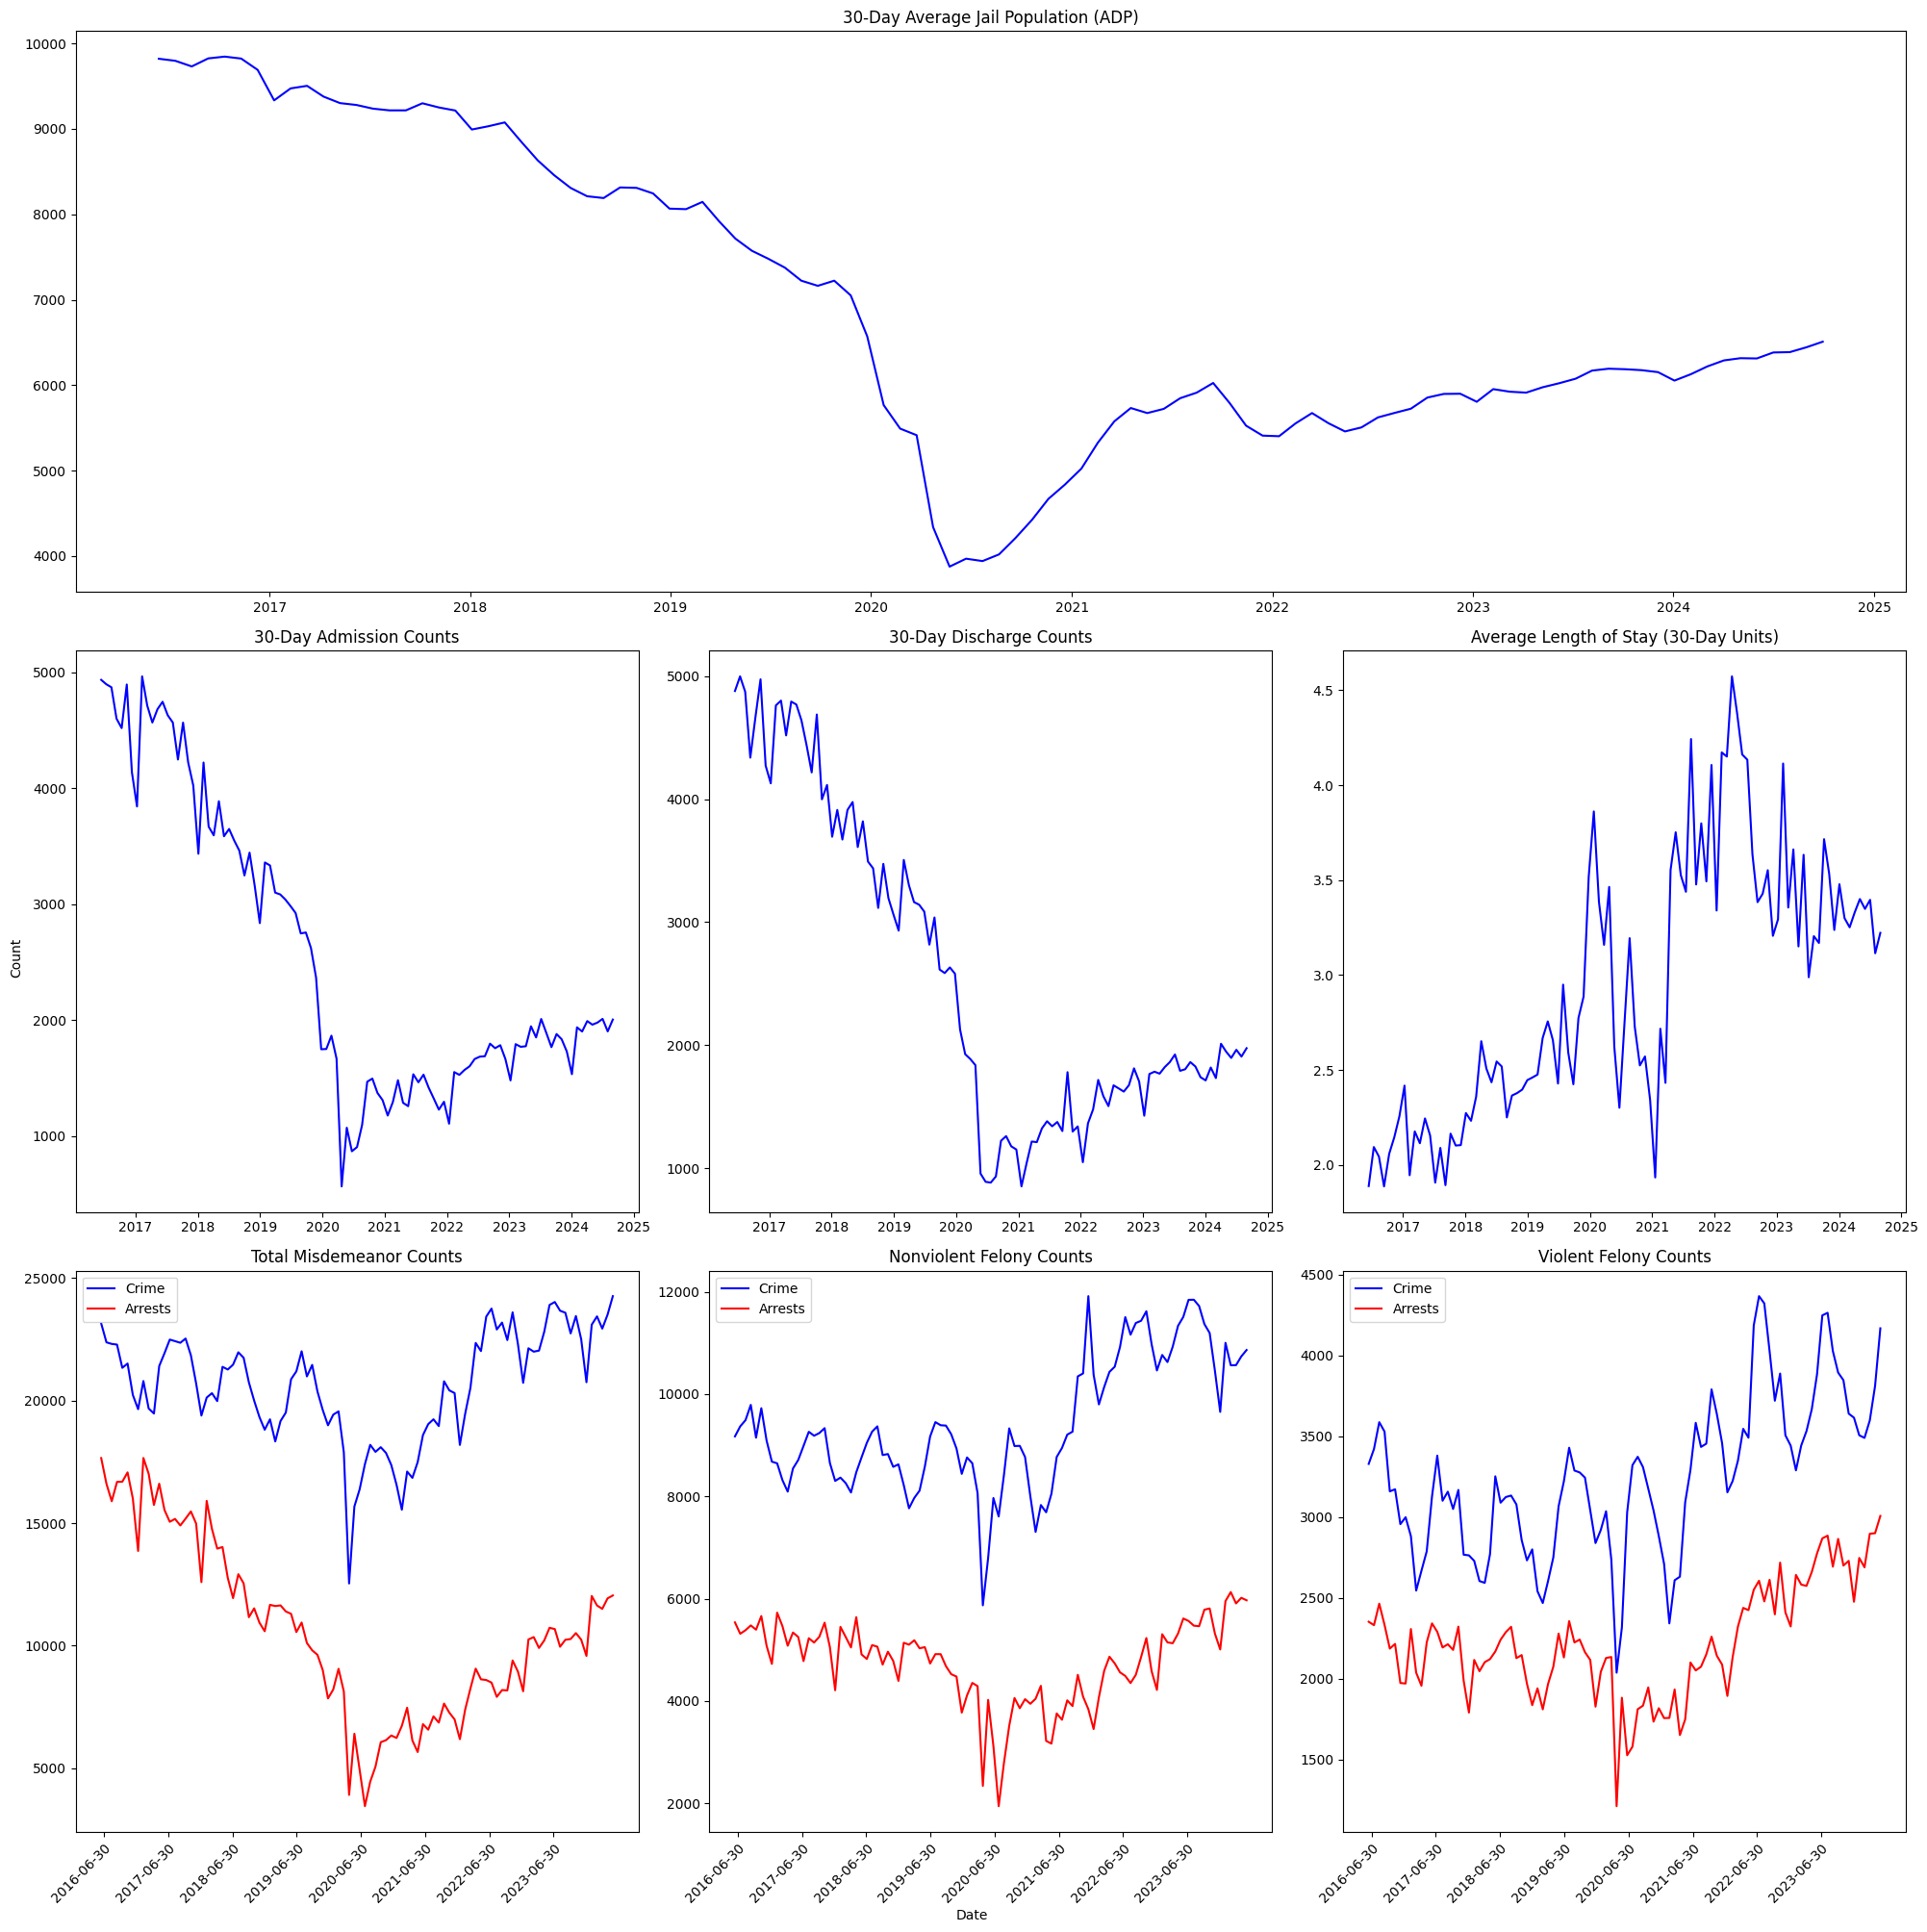

In [14]:
# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(3, 3, figure=fig)

# ADP vs End Date (spanning all three columns in the first row)
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(_30day_pop_tot['End Date'], _30day_pop_tot['ADP'], 'b', label='ADP')
ax0.set_title('30-Day Average Jail Population (ADP)')

# admission_count, discharge_count, los_days vs End Date in the second row
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(joined_doc_ivs_df['End Date'], joined_doc_ivs_df['admission_count'], 'b', label='Admission Count')
ax1.set_title('30-Day Admission Counts')

ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(joined_doc_ivs_df['End Date'], joined_doc_ivs_df['discharge_count'], 'b', label='Discharge Count')
ax2.set_title('30-Day Discharge Counts')

ax3 = fig.add_subplot(gs[1, 2])
ax3.plot(joined_doc_ivs_df['End Date'], joined_doc_ivs_df['Avg LOS (30D)'], 'b', label='LOS Days')
ax3.set_title('Average Length of Stay (30-Day Units)')


# Plot each column in crime_data vs End Date in the remaining subplots
for i, column_prefix in enumerate(['total_misdemeanor_','nonviolent_felony_','violent_felony_']):
    ax = fig.add_subplot(gs[2 + i // 3, i % 3])
    if column_prefix == 'violent_felony_':
        filtered_crime = crime_data.filter(like = column_prefix).drop(columns = 'nonviolent_felony_crimes')
        filtered_arr = arrest_data.filter(like = column_prefix).drop(columns = 'nonviolent_felony_arrest')
    else:
        filtered_crime = crime_data.filter(like = column_prefix)
        filtered_arr = arrest_data.filter(like = column_prefix)
    
    ax.plot(crime_data['End Date'],filtered_crime, 'b', label='Crime')
    ax.plot(arrest_data['End Date'], filtered_arr, 'r', label='Arrests')
    ax.set_title(column_prefix.replace('_', ' ').title()+ 'Counts')
    ax.set_xticks(pd.date_range(start=crime_data['End Date'].min(), end=crime_data['End Date'].max(), freq='12ME'))
    # ax.tick_params(axis='x', rotation=45)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    ax.legend()

# Set a common xlabel and ylabel
fig.text(0.5, 0.0, 'Date', ha='center')
fig.text(0.0, 0.5, 'Count', va='center', rotation='vertical')

# fig.suptitle('Dependent Variable (ADP) and Exogenous Variables')

plt.tight_layout()
plt.savefig('../Outputs/30_day_dv_exog_plots.png', bbox_inches='tight')
plt.show()

## Step 2: Time Series Decomposition and Stationality

Decompose the signals into trend, seasonality, and residuals. These signals are all aggregated to 30-days (monthly), thus the period will by 12.

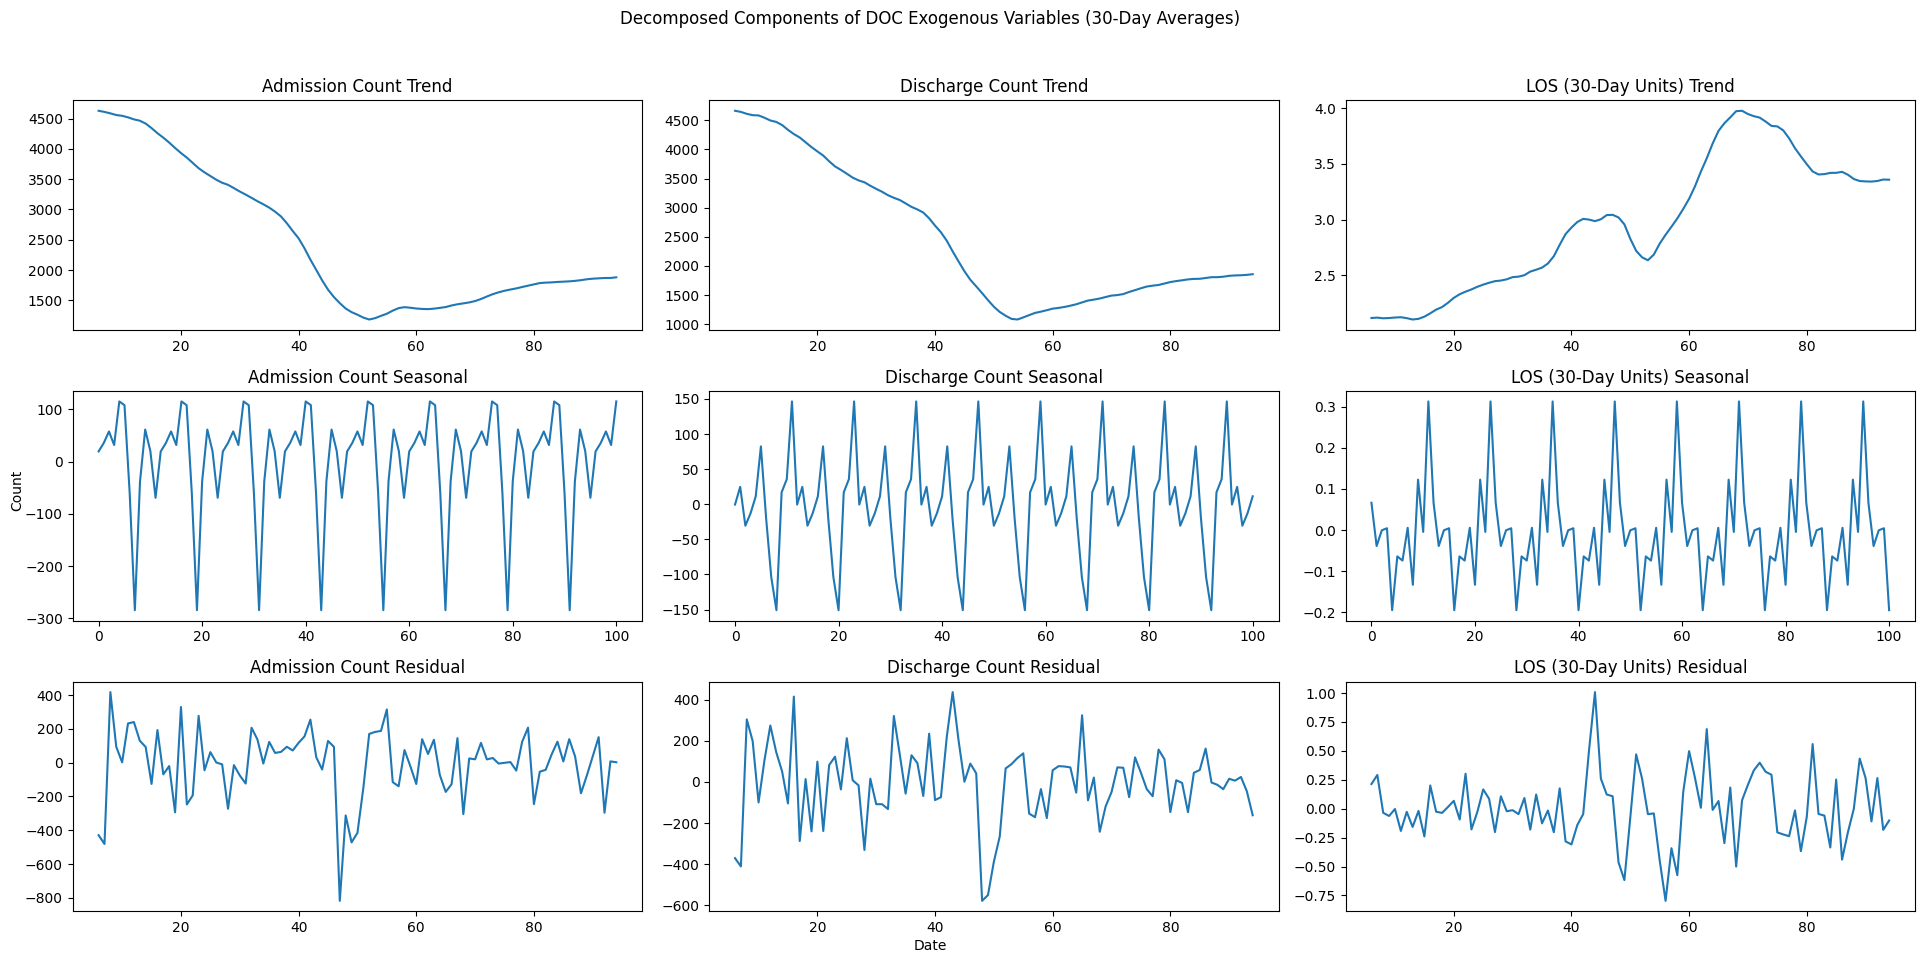

In [15]:
# Decompose the signals
admission_decomposition = seasonal_decompose(joined_doc_ivs_df['admission_count'], model='additive', period=12)
discharge_decomposition = seasonal_decompose(joined_doc_ivs_df['discharge_count'], model='additive', period=12)
los_days_decomposition = seasonal_decompose(joined_doc_ivs_df['Avg LOS (30D)'], model='additive', period=12)

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 3, figure=fig)

# Define components and titles
components = ['trend', 'seasonal', 'resid']
titles = ['Trend', 'Seasonal', 'Residual']

# Plot the decomposed components for admission_count, discharge_count, and los_days
decompositions = [admission_decomposition, discharge_decomposition, los_days_decomposition]
decomposition_titles = ['Admission Count', 'Discharge Count', 'LOS (30-Day Units)']

for i, decomposition in enumerate(decompositions):
    for j, component in enumerate(components):
        ax = fig.add_subplot(gs[j, i % 3])
        ax.plot(decomposition.trend.index, getattr(decomposition, component), label=f'{decomposition_titles[i]} {titles[j]}')
        ax.set_title(f'{decomposition_titles[i]} {titles[j]}')

# Set a common xlabel and ylabel
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

# Add a legend and title
fig.suptitle('Decomposed Components of DOC Exogenous Variables (30-Day Averages)')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/doc_exog_decomposed_components_plots_30days.png', bbox_inches='tight')
plt.show()

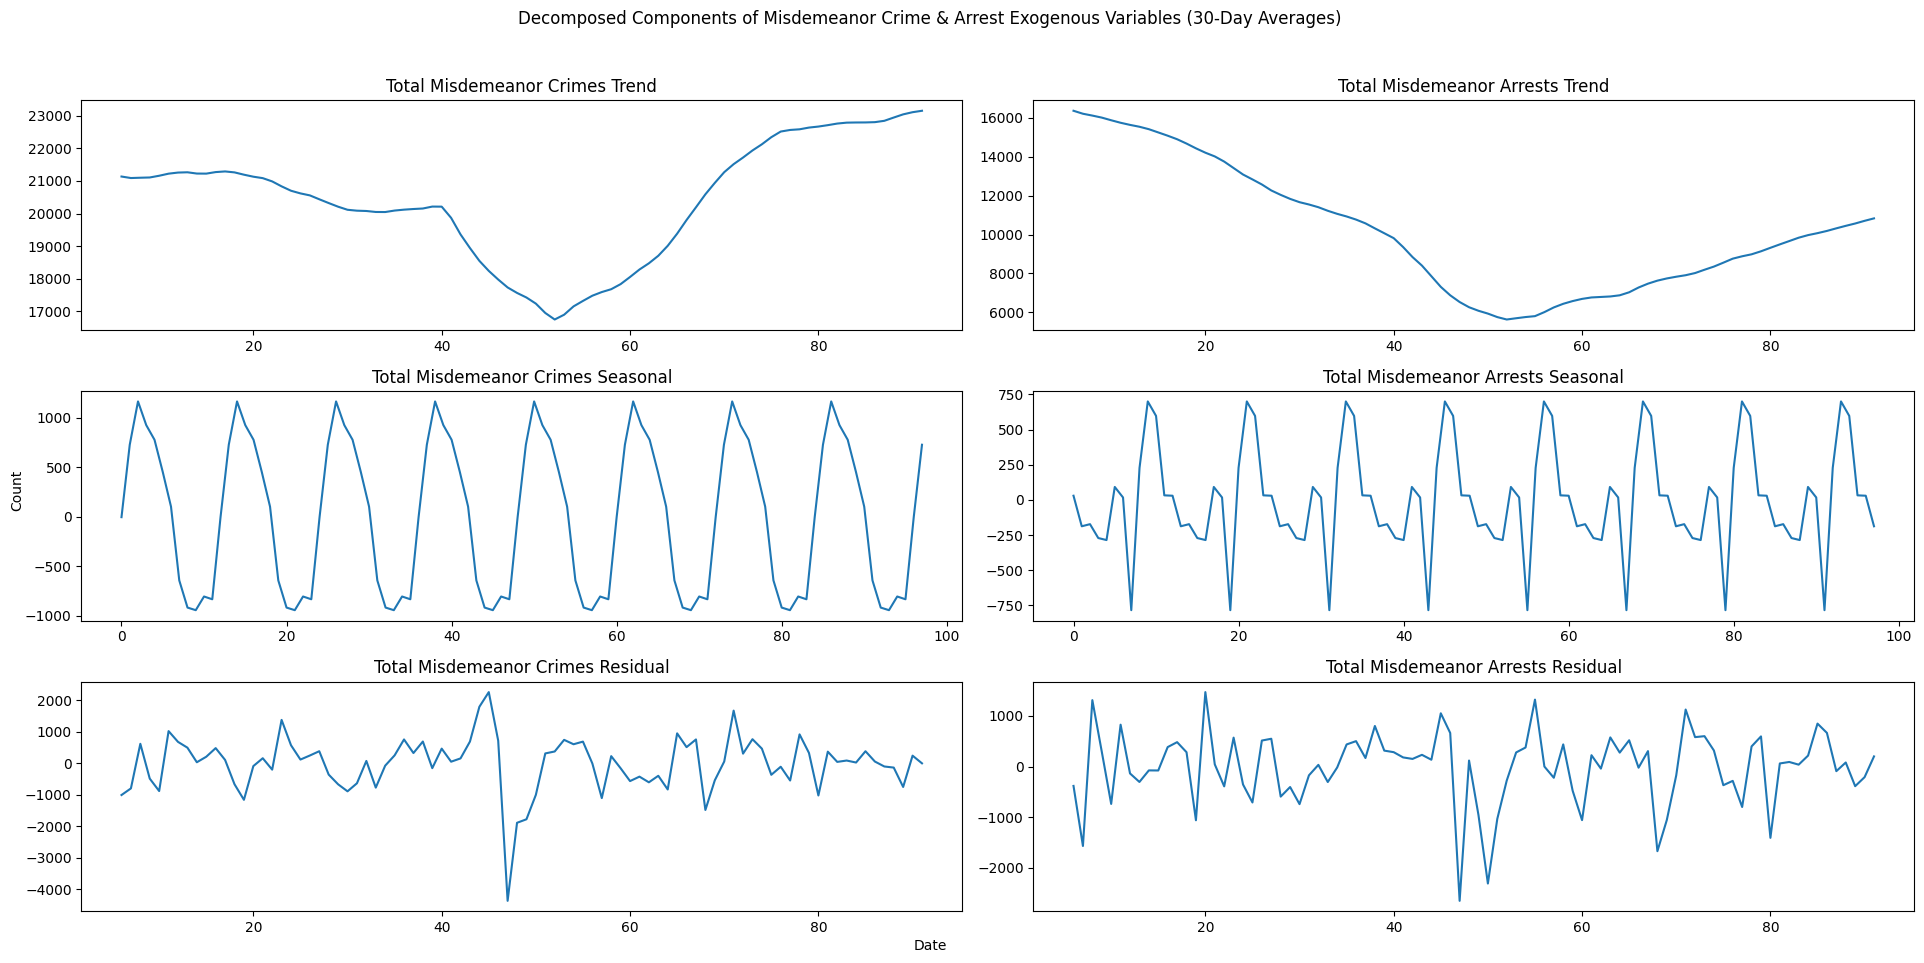

In [16]:
#Repeat for crime and arrests
# Decompose the signals
felony_crimes_decomposition = seasonal_decompose(crime_data['total_misdemeanor_crimes'], model='additive', period=12)
felony_arrest_decomposition = seasonal_decompose(arrest_data['total_misdemeanor_arrest'], model='additive', period=12)

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Define components and titles
components = ['trend', 'seasonal', 'resid']
titles = ['Trend', 'Seasonal', 'Residual']

# Plot the decomposed components for admission_count, discharge_count, and los_days
decompositions = [felony_crimes_decomposition, felony_arrest_decomposition]
decomposition_titles = ['Total Misdemeanor Crimes', 'Total Misdemeanor Arrests']

for i, decomposition in enumerate(decompositions):
    for j, component in enumerate(components):
        ax = fig.add_subplot(gs[j, i % 3])
        ax.plot(decomposition.trend.index, getattr(decomposition, component), label=f'{decomposition_titles[i]} {titles[j]}')
        ax.set_title(f'{decomposition_titles[i]} {titles[j]}')

# Set a common xlabel and ylabel
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

# Add a legend and title
fig.suptitle('Decomposed Components of Misdemeanor Crime & Arrest Exogenous Variables (30-Day Averages)')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/misd_exog_decomposed_components_plots_30days.png', bbox_inches='tight')
plt.show()

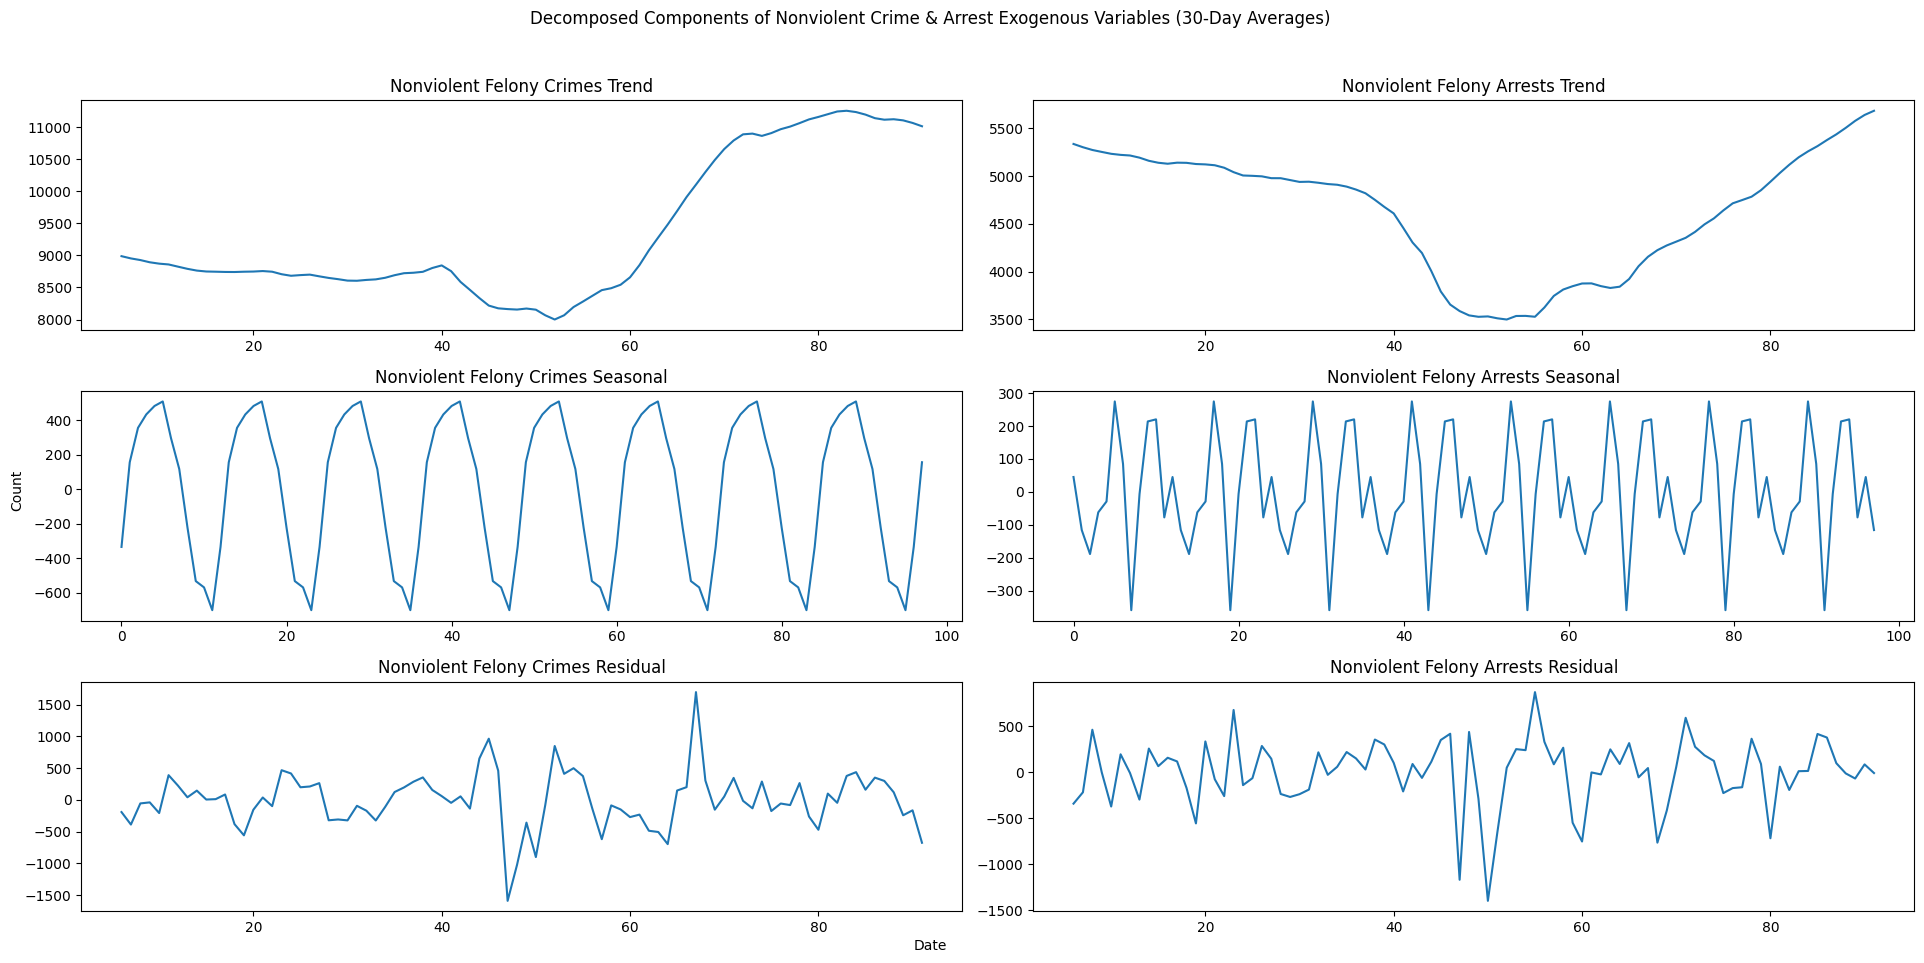

In [17]:
#Repeat for crime and arrests
# Decompose the signals
felony_crimes_decomposition = seasonal_decompose(crime_data['nonviolent_felony_crimes'], model='additive', period=12)
felony_arrest_decomposition = seasonal_decompose(arrest_data['nonviolent_felony_arrest'], model='additive', period=12)

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Define components and titles
components = ['trend', 'seasonal', 'resid']
titles = ['Trend', 'Seasonal', 'Residual']

# Plot the decomposed components for admission_count, discharge_count, and los_days
decompositions = [felony_crimes_decomposition, felony_arrest_decomposition]
decomposition_titles = ['Nonviolent Felony Crimes', 'Nonviolent Felony Arrests']

for i, decomposition in enumerate(decompositions):
    for j, component in enumerate(components):
        ax = fig.add_subplot(gs[j, i % 3])
        ax.plot(decomposition.trend.index, getattr(decomposition, component), label=f'{decomposition_titles[i]} {titles[j]}')
        ax.set_title(f'{decomposition_titles[i]} {titles[j]}')

# Set a common xlabel and ylabel
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

# Add a legend and title
fig.suptitle('Decomposed Components of Nonviolent Crime & Arrest Exogenous Variables (30-Day Averages)')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/nvfo_exog_decomposed_components_plots_30days.png', bbox_inches='tight')
plt.show()

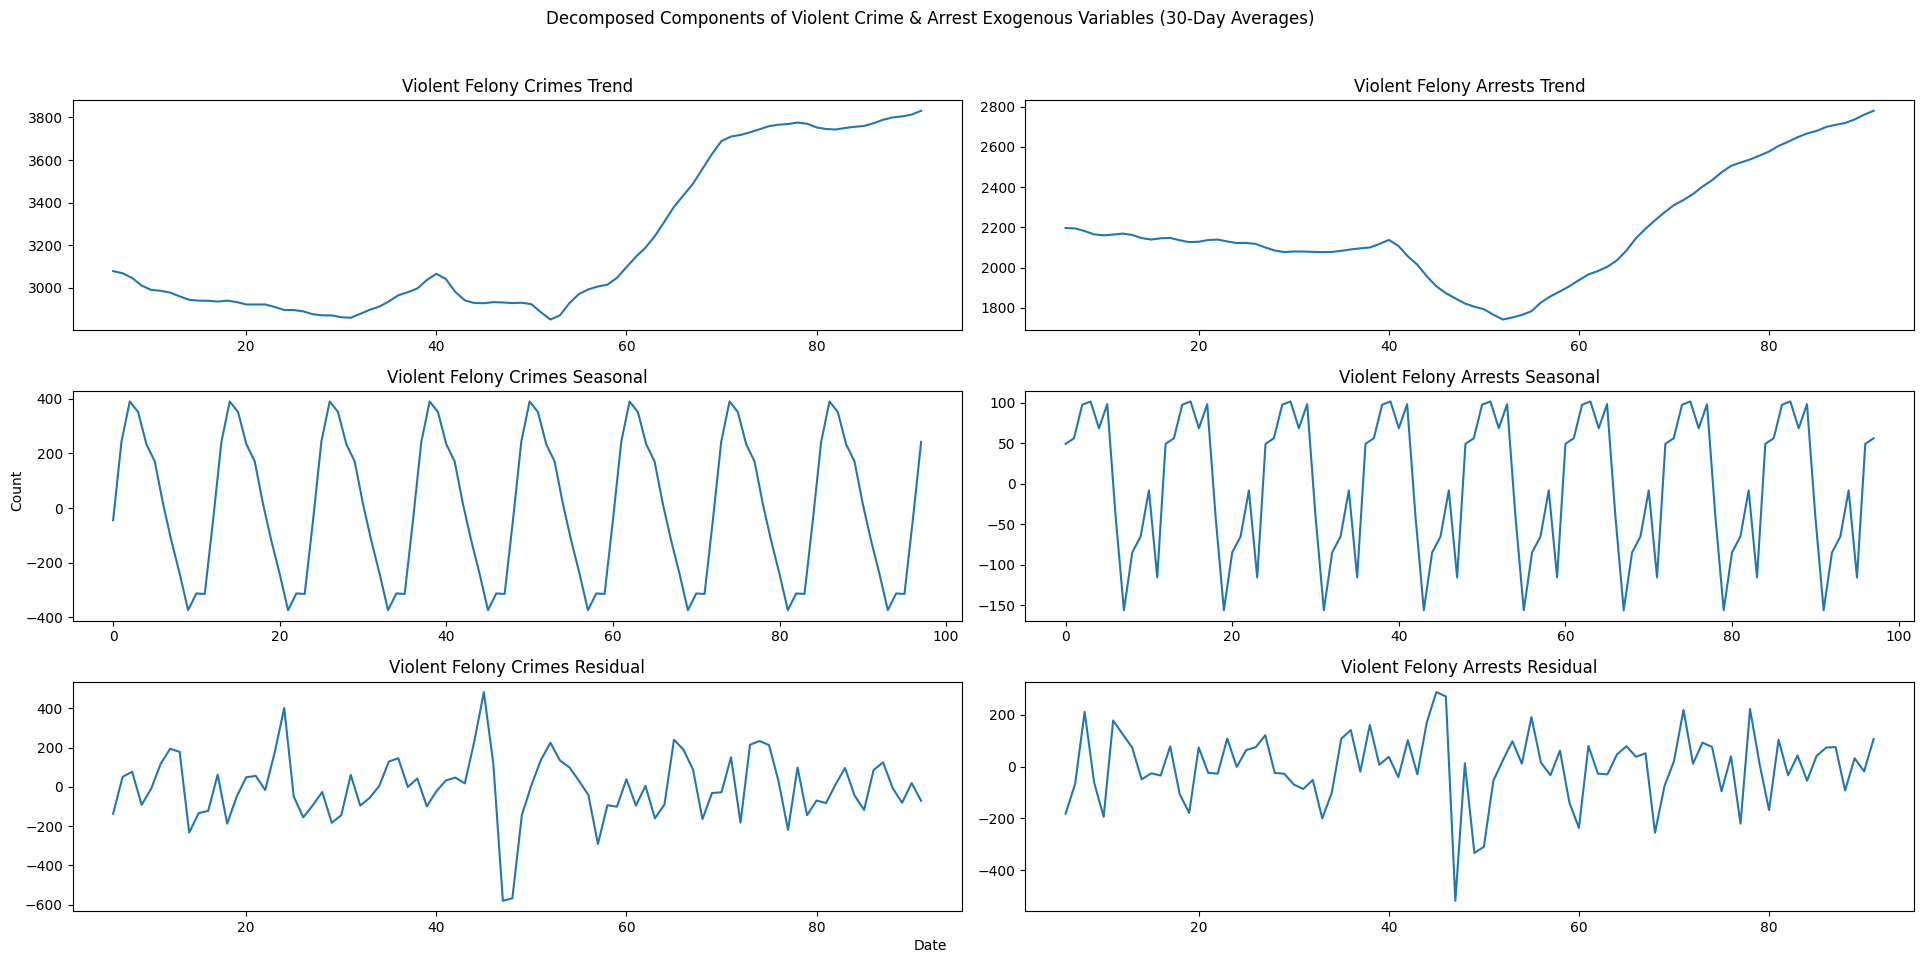

In [18]:
#Repeat for crime and arrests
# Decompose the signals
felony_crimes_decomposition = seasonal_decompose(crime_data['violent_felony_crimes'], model='additive', period=12)
felony_arrest_decomposition = seasonal_decompose(arrest_data['violent_felony_arrest'], model='additive', period=12)

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Define components and titles
components = ['trend', 'seasonal', 'resid']
titles = ['Trend', 'Seasonal', 'Residual']

# Plot the decomposed components for admission_count, discharge_count, and los_days
decompositions = [felony_crimes_decomposition, felony_arrest_decomposition]
decomposition_titles = ['Violent Felony Crimes', 'Violent Felony Arrests']

for i, decomposition in enumerate(decompositions):
    for j, component in enumerate(components):
        ax = fig.add_subplot(gs[j, i % 3])
        ax.plot(decomposition.trend.index, getattr(decomposition, component), label=f'{decomposition_titles[i]} {titles[j]}')
        ax.set_title(f'{decomposition_titles[i]} {titles[j]}')

# Set a common xlabel and ylabel
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

# Add a legend and title
fig.suptitle('Decomposed Components of Violent Crime & Arrest Exogenous Variables (30-Day Averages)')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/vfo_exog_decomposed_components_plots_30days.png', bbox_inches='tight')
plt.show()

Determine stationality of signal

In [19]:
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller

In [20]:
for col in joined_doc_ivs_df.columns[2:]:
    print(f'The optimal d coefficient for {col} signal with alpha = 0.05 is: ', ndiffs(joined_doc_ivs_df[col], test='adf'))
    print(f'The optimal d coefficient for {col} signal with alpha = 0.025 is: ', ndiffs(joined_doc_ivs_df[col], test='adf', alpha = 0.025))

The optimal d coefficient for admission_count signal with alpha = 0.05 is:  1
The optimal d coefficient for admission_count signal with alpha = 0.025 is:  1
The optimal d coefficient for discharge_count signal with alpha = 0.05 is:  1
The optimal d coefficient for discharge_count signal with alpha = 0.025 is:  1
The optimal d coefficient for Avg LOS Days signal with alpha = 0.05 is:  1
The optimal d coefficient for Avg LOS Days signal with alpha = 0.025 is:  1
The optimal d coefficient for Avg LOS (30D) signal with alpha = 0.05 is:  1
The optimal d coefficient for Avg LOS (30D) signal with alpha = 0.025 is:  1


In [21]:
#print the p-values
for col in joined_doc_ivs_df.columns[2:]:
    y = joined_doc_ivs_df[col]
    result = adfuller(y.diff().dropna())
    print(f'{col} ADF Statistic: %f' % result[0])
    print(f'{col} p-value: %f' % result[1])

admission_count ADF Statistic: -1.656421
admission_count p-value: 0.453694
discharge_count ADF Statistic: -13.365817
discharge_count p-value: 0.000000
Avg LOS Days ADF Statistic: -3.586368
Avg LOS Days p-value: 0.006027
Avg LOS (30D) ADF Statistic: -3.586368
Avg LOS (30D) p-value: 0.006027


In [22]:
crime_arr_cols = ['total_misdemeanor_','nonviolent_felony_','violent_felony_']
for col in crime_arr_cols:
    print(f'The optimal d coefficient for {col+"crimes"} signal with alpha = 0.05 is: ', ndiffs(crime_data[col+"crimes"], test='adf'))
    print(f'The optimal d coefficient for {col+"crimes"} signal with alpha = 0.025 is: ', ndiffs(crime_data[col+"crimes"], test='adf', alpha = 0.025))
    print()

The optimal d coefficient for total_misdemeanor_crimes signal with alpha = 0.05 is:  1
The optimal d coefficient for total_misdemeanor_crimes signal with alpha = 0.025 is:  1

The optimal d coefficient for nonviolent_felony_crimes signal with alpha = 0.05 is:  1
The optimal d coefficient for nonviolent_felony_crimes signal with alpha = 0.025 is:  1

The optimal d coefficient for violent_felony_crimes signal with alpha = 0.05 is:  0
The optimal d coefficient for violent_felony_crimes signal with alpha = 0.025 is:  0



In [23]:
#print the p-values
for col in crime_arr_cols:
    y = crime_data[col+"crimes"]
    result = adfuller(y.diff().dropna())
    print(f'{col+"crimes"} ADF Statistic: %f' % result[0])
    print(f'{col+"crimes"} p-value: %f' % result[1])

total_misdemeanor_crimes ADF Statistic: -10.490603
total_misdemeanor_crimes p-value: 0.000000
nonviolent_felony_crimes ADF Statistic: -5.686372
nonviolent_felony_crimes p-value: 0.000001
violent_felony_crimes ADF Statistic: -7.299052
violent_felony_crimes p-value: 0.000000


In [24]:
for col in crime_arr_cols:
    print(f'The optimal d coefficient for {col+"arrest"} signal with alpha = 0.05 is: ', ndiffs(arrest_data[col+"arrest"], test='adf'))
    print(f'The optimal d coefficient for {col+"arrest"} signal with alpha = 0.025 is: ', ndiffs(arrest_data[col+"arrest"], test='adf', alpha = 0.025))
    print()

The optimal d coefficient for total_misdemeanor_arrest signal with alpha = 0.05 is:  1
The optimal d coefficient for total_misdemeanor_arrest signal with alpha = 0.025 is:  1

The optimal d coefficient for nonviolent_felony_arrest signal with alpha = 0.05 is:  1
The optimal d coefficient for nonviolent_felony_arrest signal with alpha = 0.025 is:  1

The optimal d coefficient for violent_felony_arrest signal with alpha = 0.05 is:  1
The optimal d coefficient for violent_felony_arrest signal with alpha = 0.025 is:  1



In [25]:
#print the p-values
for col in crime_arr_cols:
    y = arrest_data[col+"arrest"]
    result = adfuller(y.diff().dropna())
    print(f'{col+"arrest"} ADF Statistic: %f' % result[0])
    print(f'{col+"arrest"} p-value: %f' % result[1])

total_misdemeanor_arrest ADF Statistic: -11.014614
total_misdemeanor_arrest p-value: 0.000000
nonviolent_felony_arrest ADF Statistic: -11.710409
nonviolent_felony_arrest p-value: 0.000000
violent_felony_arrest ADF Statistic: -15.064808
violent_felony_arrest p-value: 0.000000


Based on the outputs above, the majority of our exogenous variables are not stationary, with the exception of violent felony crimes. Therefore, we should expect these signals to have a differencing coefficient during ARIMA modeling and optimization.

## Plot ACF and PACF of Exogenous Variables

**Rules for identifying the numbers of AR and MA terms:**

* Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR(p) terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

* Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA(q) term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

* Rule 3: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.


In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

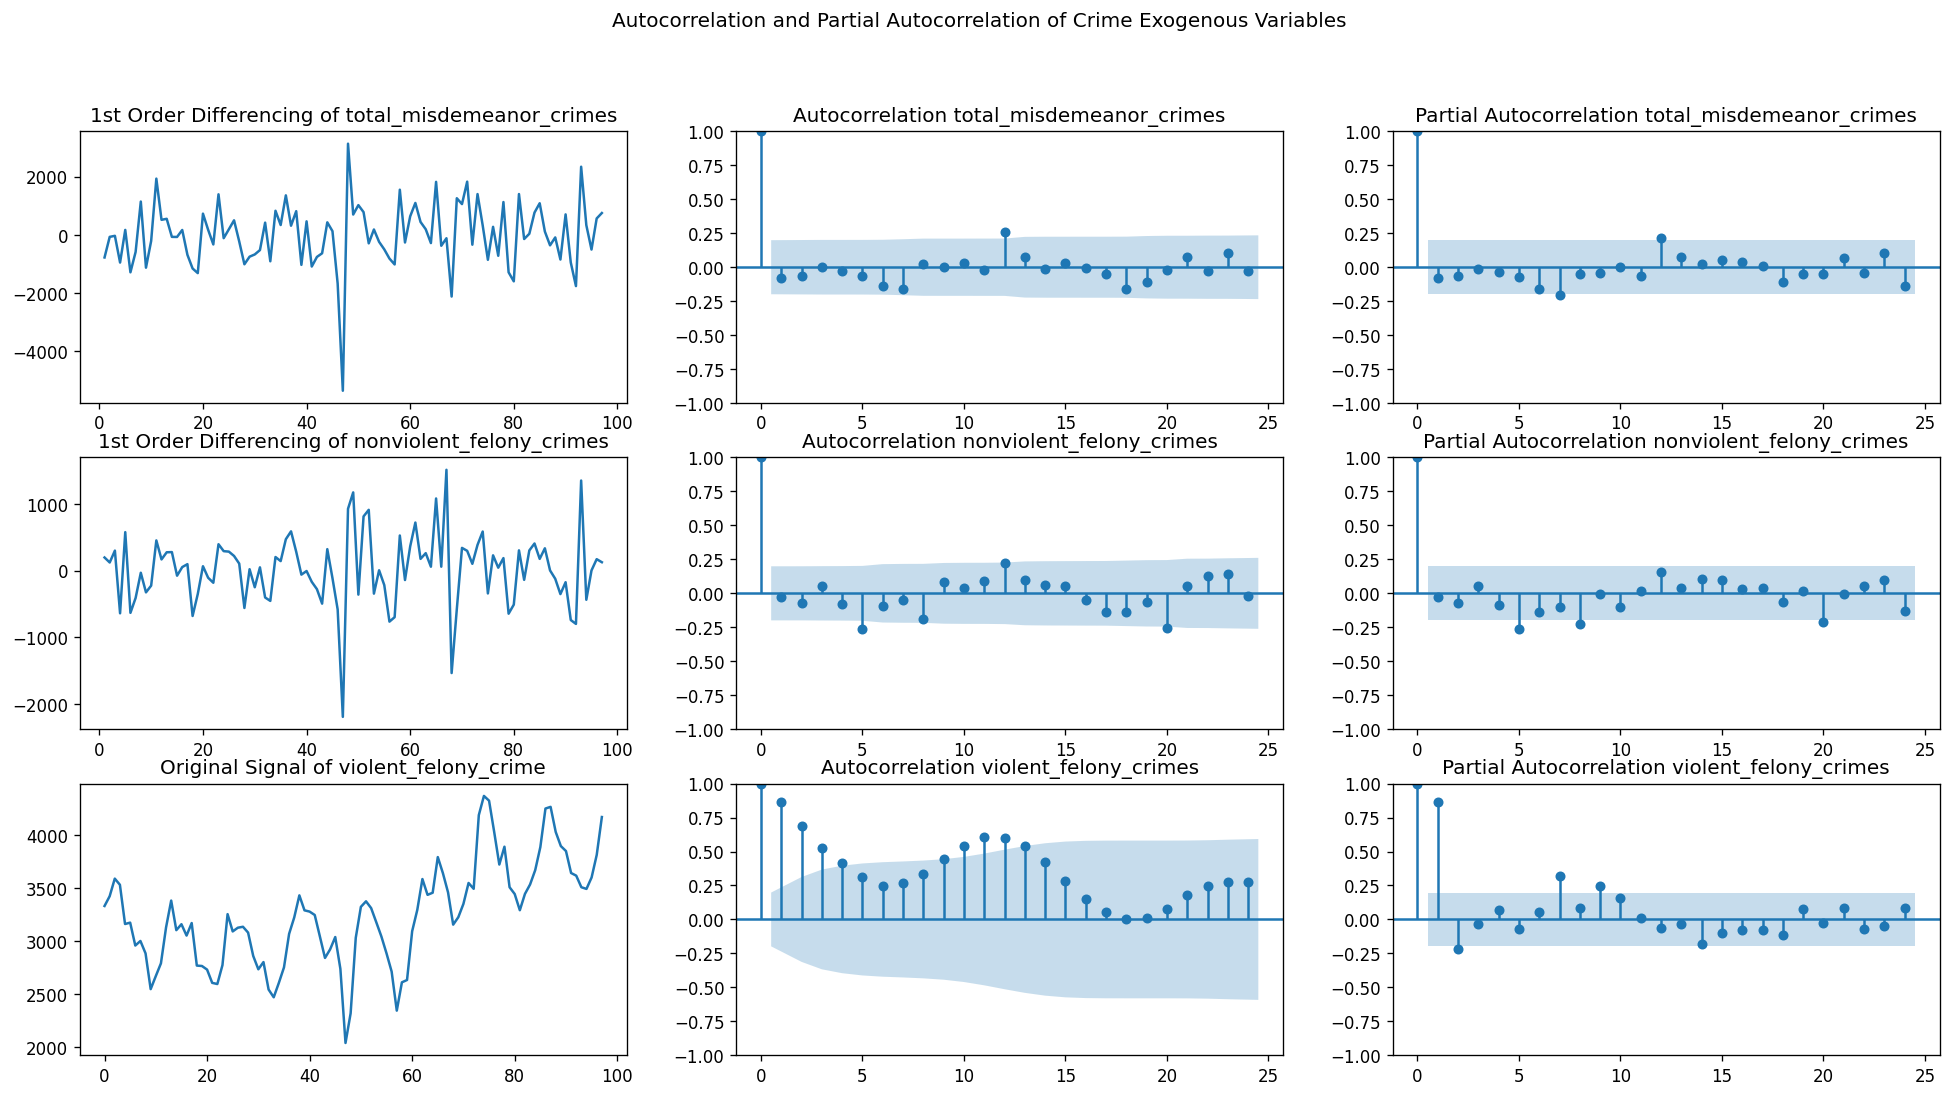

In [27]:
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3)

for i,col in enumerate(crime_arr_cols):
    y = crime_data[col+"crimes"]
    #determine d coeff
    d = ndiffs(y, test='adf')
    new_signal = y.diff().dropna() if d == 1 else y 
    # 1st Differencing
    first_title = f'1st Order Differencing of {col}crimes' if d == 1 else f'Original Signal of {col}crime'
    axes[i, 0].plot(new_signal); axes[i, 0].set_title(first_title)

    plot_acf(new_signal, lags = 24, ax = axes[i, 1])
    axes[i, 1].set_title(f'Autocorrelation {col}crimes')

    plot_pacf(new_signal, lags = 24, ax=axes[i, 2])
    axes[i, 2].set_title(f'Partial Autocorrelation {col}crimes')


fig.suptitle("Autocorrelation and Partial Autocorrelation of Crime Exogenous Variables")
plt.savefig("../Outputs/crime_exog_acf_pacf_plots.png",bbox_inches = 'tight')
plt.show()

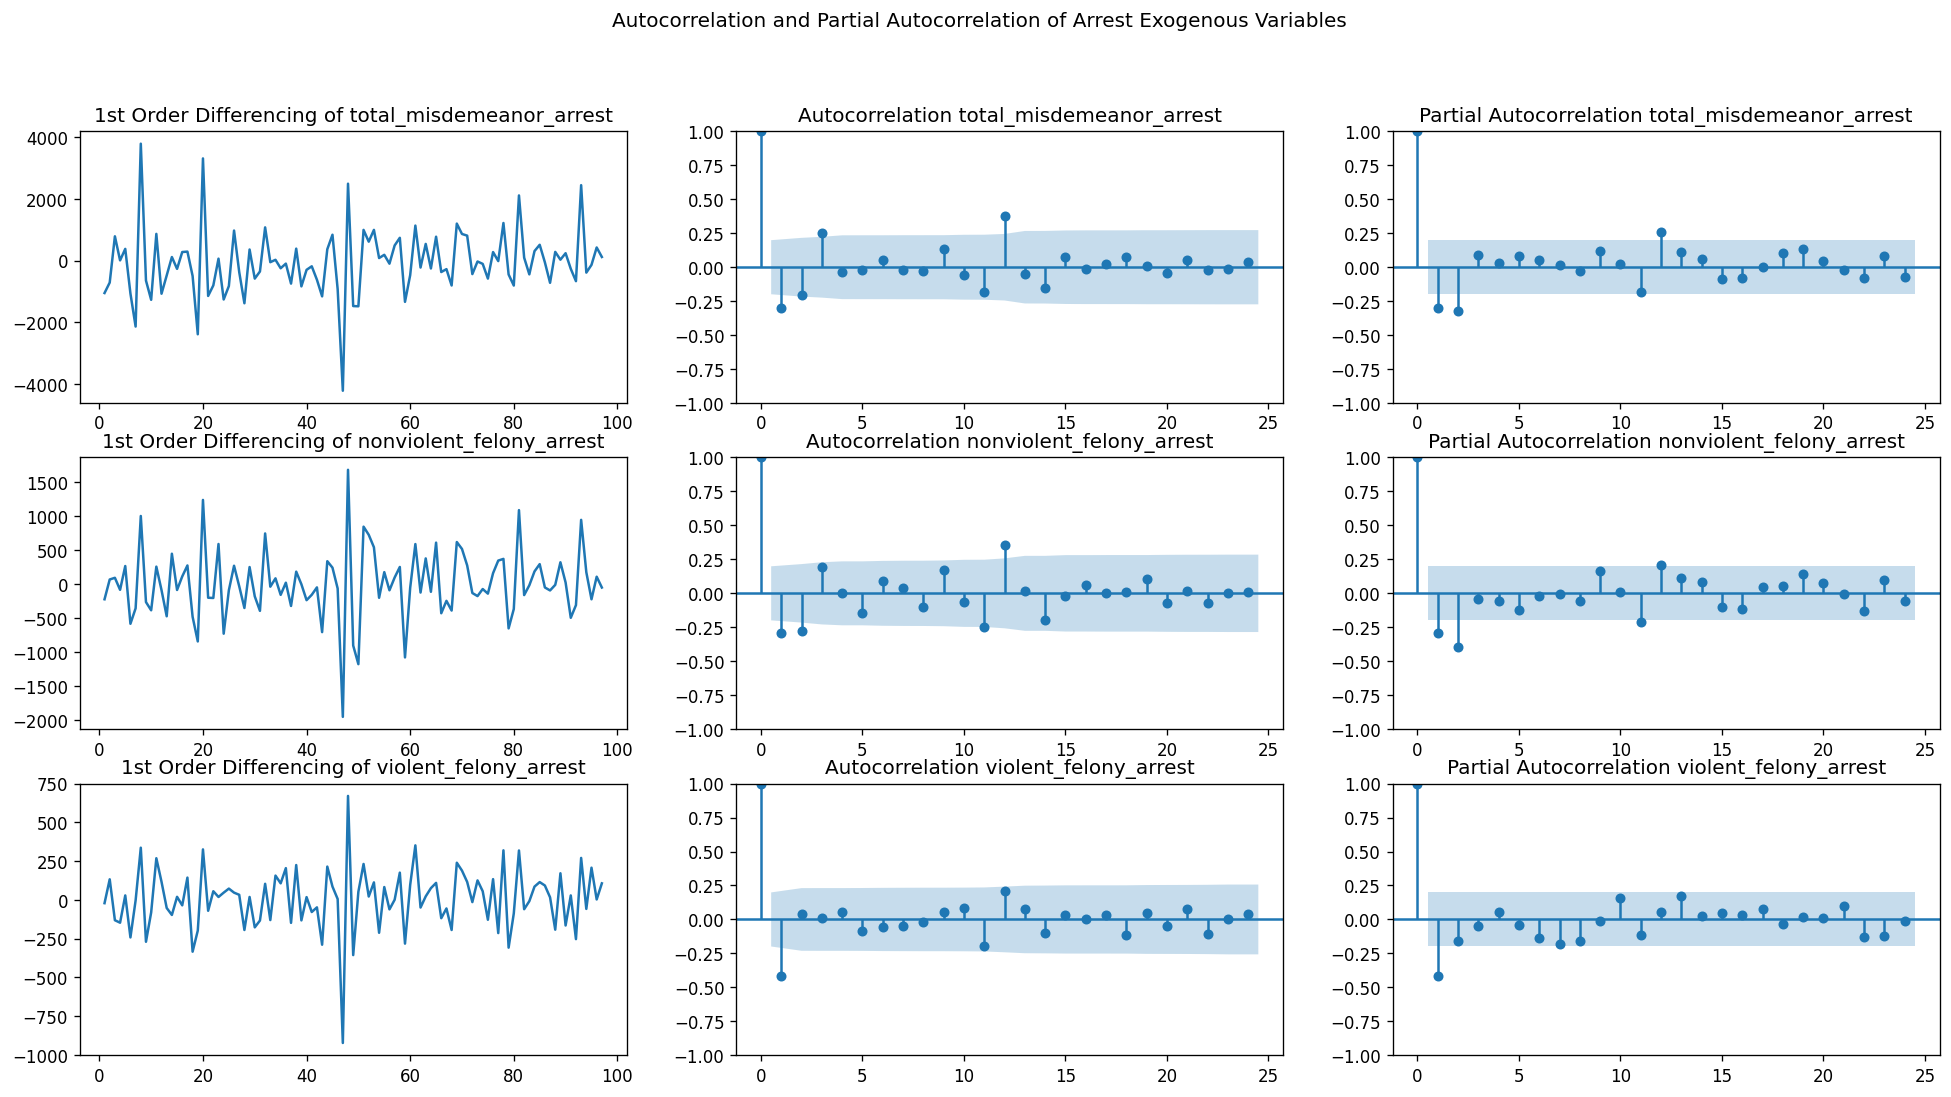

In [28]:
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3)

for i,col in enumerate(crime_arr_cols):
    y = arrest_data[col+"arrest"]
    #determine d coeff
    d = ndiffs(y, test='adf')
    new_signal = y.diff().dropna() if d == 1 else y 
    # 1st Differencing
    first_title = f'1st Order Differencing of {col}arrest' if d == 1 else f'Original Signal of {col}arrest'
    axes[i, 0].plot(new_signal); axes[i, 0].set_title(first_title)

    plot_acf(new_signal, lags = 24, ax = axes[i, 1])
    axes[i, 1].set_title(f'Autocorrelation {col}arrest')

    plot_pacf(new_signal, lags = 24, ax=axes[i, 2])
    axes[i, 2].set_title(f'Partial Autocorrelation {col}arrest')


fig.suptitle("Autocorrelation and Partial Autocorrelation of Arrest Exogenous Variables")
plt.savefig("../Outputs/arrest_exog_acf_pacf_plots.png",bbox_inches = 'tight')
plt.show()

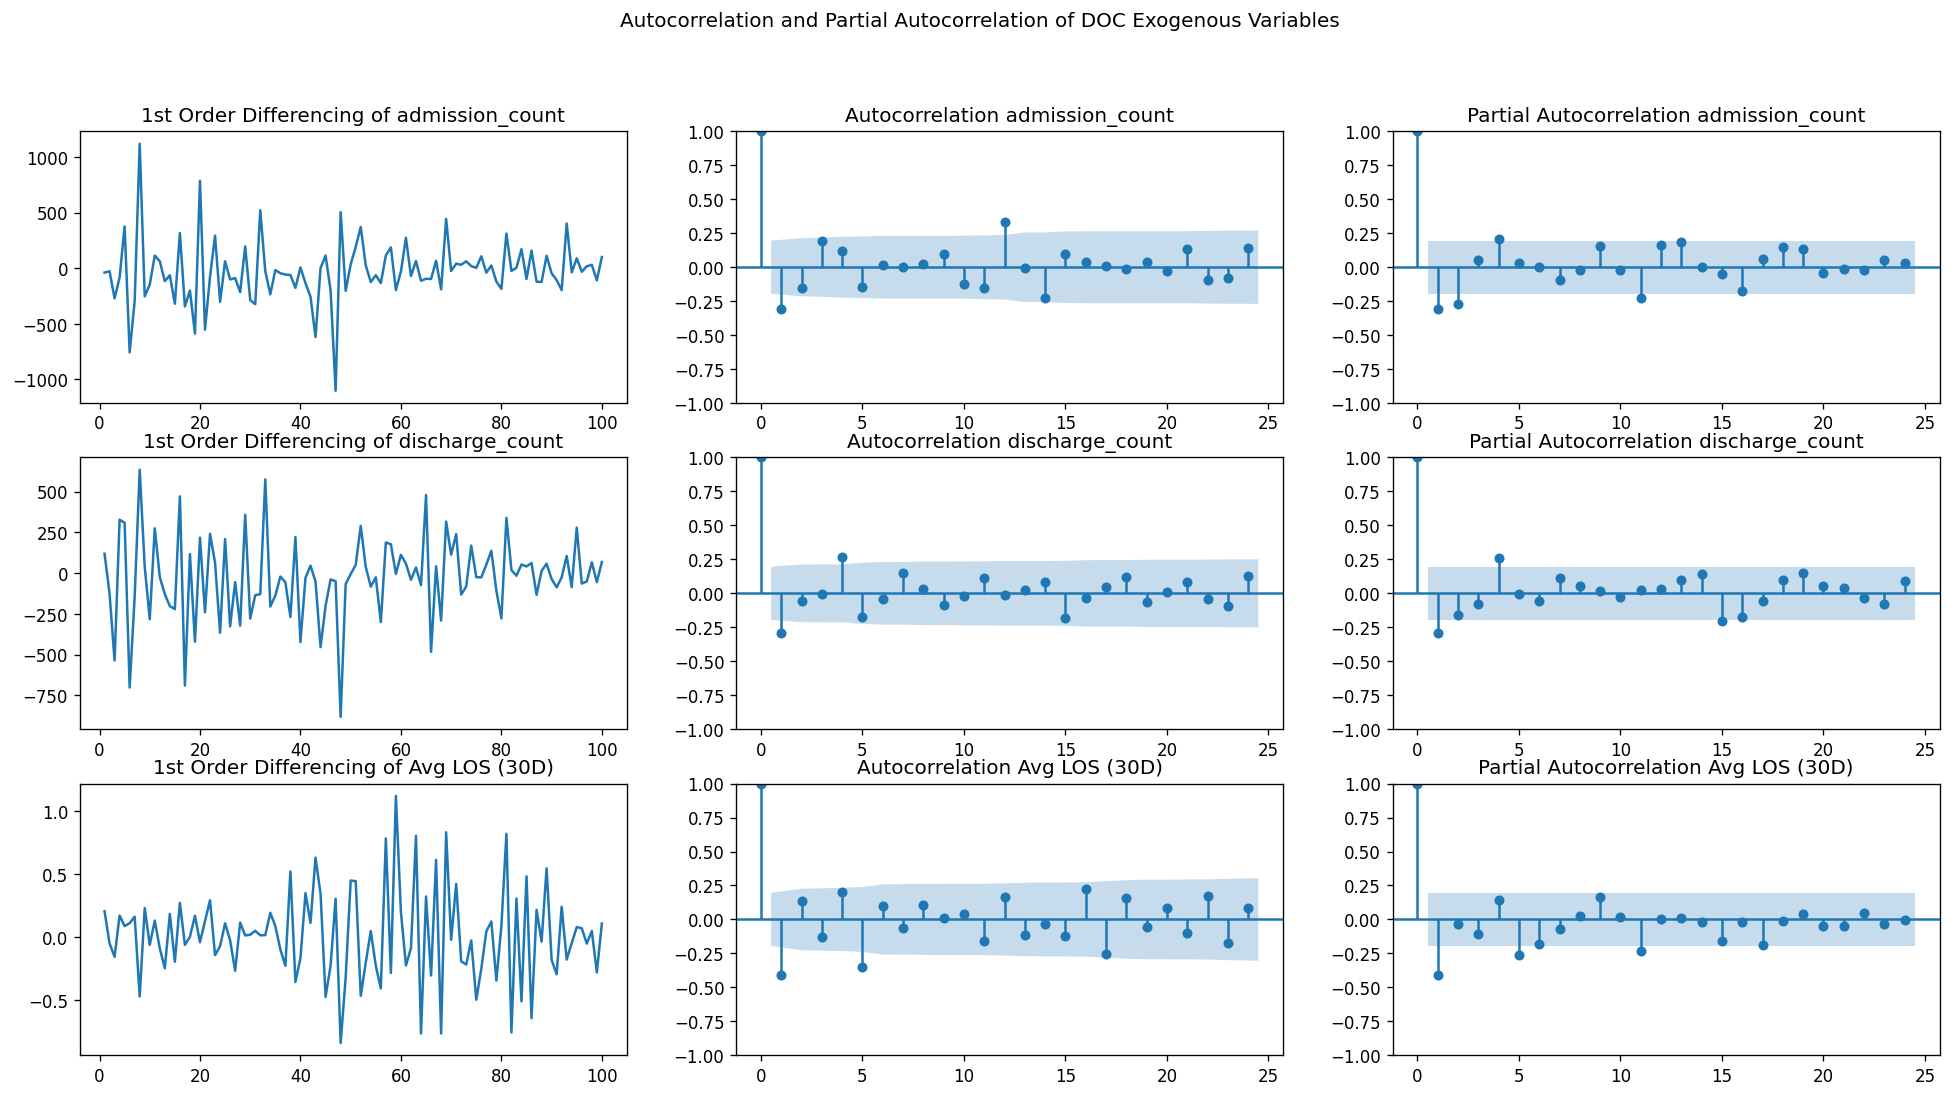

In [29]:
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3)

for i,col in enumerate(joined_doc_ivs_df.columns[2:]):
    if col == 'Avg LOS Days':
        continue
    if col == 'Avg LOS (30D)':
        i = i -1
    y = joined_doc_ivs_df[col]
    #determine d coeff
    d = ndiffs(y, test='adf')
    new_signal = y.diff().dropna() if d == 1 else y 
    # 1st Differencing
    first_title = f'1st Order Differencing of {col}' if d == 1 else f'Original Signal of {col}'
    axes[i, 0].plot(new_signal); axes[i, 0].set_title(first_title)

    plot_acf(new_signal, lags = 24, ax = axes[i, 1])
    axes[i, 1].set_title(f'Autocorrelation {col}')

    plot_pacf(new_signal, lags = 24, ax=axes[i, 2])
    axes[i, 2].set_title(f'Partial Autocorrelation {col}')


fig.suptitle("Autocorrelation and Partial Autocorrelation of DOC Exogenous Variables")
plt.savefig("../Outputs/doc_exog_acf_pacf_plots.png",bbox_inches = 'tight')
plt.show()

Most of these signals appear to be over differenced with the coefficient of d = 1 so we should anticipate having non-zero moving average (q) terms in our ARIMA models. Since violent felony crimes has a d values of 0, this signal seems to be underdifferenced and should have autregressive (p) terms in the final ARIMA model. However, if we decide to difference this signal, I am sure we will need to incoporate moving average terms.

In the next script, we will conduct a grid-search and rolling window method to pick the optimal parameters for each of these variables. This will them help us determine which of the variables, if any, optimizes the performance of our final model to predict the ADP for the next year.